FileNotFoundError: [Errno 2] No such file or directory: 'res_fn_abs_n_1000_stregth_0.5_eps_0.1.jbl'

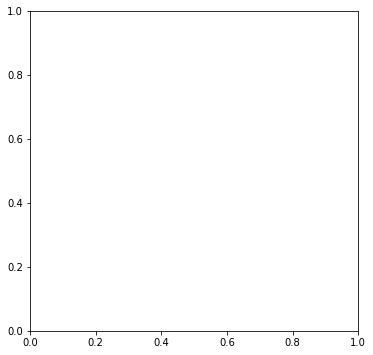

In [1]:
### imports
import warnings
warnings.simplefilter('ignore')
import itertools
import numpy as np
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from mliv.dgps import get_data, get_tau_fn, fn_dict
from mliv.neuralnet.utilities import mean_ci
from mliv.neuralnet import AGMMEarlyStop as AGMM
from mliv.neuralnet.moments import avg_small_diff
from sklearn.ensemble import RandomForestRegressor
import joblib

def plot_results(fname, n, iv_strength, dr, tmle, ipw, direct, true):
    plt.title(f'fname={fname}, n={n}, strength={iv_strength}, true={true:.3f}\n'
              f'dr: Cov={np.mean((dr[:, 1] <= true) & (true <= dr[:, 2])):.3f}, '
              f'rmse={np.sqrt(np.mean((dr[:, 0]-true)**2)):.3f}, '
              f'bias={np.mean((dr[:, 0]-true)):.3f}\n'
              f'tmle: Cov={np.mean((tmle[:, 1] <= true) & (true <= tmle[:, 2])):.3f}, '
              f'rmse={np.sqrt(np.mean((tmle[:, 0]-true)**2)):.3f}, '
              f'bias={np.mean((tmle[:, 0]-true)):.3f}\n'
              f'ipw: Cov={np.mean((ipw[:, 1] <= true) & (true <= ipw[:, 2])):.3f}, '
              f'rmse={np.sqrt(np.mean((ipw[:, 0]-true)**2)):.3f}, '
              f'bias={np.mean((ipw[:, 0]-true)):.3f}\n'
              f'direct: Cov={np.mean((direct[:, 1] <= true) & (true <= direct[:, 2])):.3f}, '
              f'rmse={np.sqrt(np.mean((direct[:, 0]-true)**2)):.3f}, '
              f'bias={np.mean((direct[:, 0]-true)):.3f}\n')
    plt.hist(dr[:, 0], label='dr')
    plt.hist(tmle[:, 0], label='tmle', alpha=.4)
    plt.hist(ipw[:, 0], label='ipw', alpha=.4)
    plt.hist(direct[:, 0], label='direct', alpha=.4)
    plt.legend()


n_z = 1
n_t = 1
dgp_num = 5
epsilon = 0.1 # average finite difference epsilon
moment_fn = lambda x, fn, device: avg_small_diff(x, fn, device, epsilon)

for fname in ['abs', '2dpoly']:
    plt.figure(figsize=(20, 20))
    it = 1
    for n in [1000, 2000]:
        for iv_strength in [.5, .7, .9]:
            plt.subplot(3, 3, it)
            true, results = joblib.load(f'res_fn_{fname}_n_{n}_stregth_{iv_strength}_eps_{0.1}.jbl')
            dr = np.array([r[0] for r in results])
            tmle = np.array([r[1] for r in results])
            ipw = np.array([r[2] for r in results])
            direct = np.array([r[3] for r in results])
            plot_results(fname, n, iv_strength, dr, tmle, ipw, direct, true)
            it += 1
    plt.tight_layout()
    plt.show()

In [65]:
import pandas as pd

resd = {}
for fname in ['abs', '2dpoly', 'sigmoid', 'sin']:
    resd[fname] = {}
    for n in [500, 1000, 2000]:
        nkey = f'$n={n}$'
        resd[fname][nkey] = {}
        for iv_strength in [.5, .7, .9]:
            true, results = joblib.load(f'res_fn_{fname}_n_{n}_stregth_{iv_strength}_eps_{0.1}.jbl')
            ivkey = f'$\rho={iv_strength}$'
            resd[fname][nkey][ivkey] = {}
            for it, method in enumerate(['dr', 'tmle', 'ipw', 'direct']):
                data = np.array([r[it] for r in results])
                if method in ['dr', 'tmle']:
                    cov = f'{100*np.mean((data[:, 1] <= true) & (true <= data[:, 2])):.0f}'
                else:
                    cov = 'NA'
                resd[fname][nkey][ivkey][method] = {
                                'cov': cov,
                                'rmse': f'{np.sqrt(np.mean((data[:, 0]-true)**2)):.3f}',
                                'bias': f'{np.abs(np.mean((data[:, 0]-true))):.3f}'}
            resd[fname][nkey][ivkey] = pd.DataFrame(resd[fname][nkey][ivkey])
        resd[fname][nkey] = pd.concat(resd[fname][nkey])
    resd[fname] = pd.concat(resd[fname])

display(pd.concat(resd).unstack(level=3))
print(pd.concat(resd).unstack(level=3).to_latex(bold_rows=True, multirow=True,
                                                multicolumn=True, escape=False,
                                                column_format='lll||lll|lll|lll|lll|',
                                                multicolumn_format='c|'))

dr               tmle               ipw         \
                            cov   rmse   bias  cov   rmse   bias cov   rmse   
abs     $n=500$  $\rho=0.5$  61  0.151  0.012   61  0.089  0.024  NA  0.028   
                 $\rho=0.7$  87  0.055  0.006   81  0.057  0.006  NA  0.036   
                 $\rho=0.9$  90  0.054  0.005   90  0.041  0.005  NA  0.043   
        $n=1000$ $\rho=0.5$  89  0.042  0.004   83  0.047  0.008  NA  0.036   
                 $\rho=0.7$  96  0.035  0.006   96  0.035  0.006  NA  0.035   
                 $\rho=0.9$  93  0.033  0.005   96  0.028  0.003  NA  0.039   
        $n=2000$ $\rho=0.5$  93  0.035  0.001   95  0.033  0.000  NA  0.040   
                 $\rho=0.7$  93  0.029  0.002   97  0.026  0.001  NA  0.034   
                 $\rho=0.9$  95  0.025  0.001   97  0.021  0.002  NA  0.034   
2dpoly  $n=500$  $\rho=0.5$  51  0.142  0.072   64  0.104  0.002  NA  0.267   
                 $\rho=0.7$  77  0.101  0.039   71  0.082  0.013  NA  0.143   
                 $\rho=0.9$  88  0.058  0.004   84  0.051  0.006  NA  0.097   
        $n=1000$ $\rho=0.5$  85  0.066  0.007   84  0.065  0.004  NA  0.145   
                 $\rho=0.7$  91  0.045  0.002   89  0.044  0.002  NA  0.061   
                 $\rho=0.9$  92  0.038  0.001   93  0.035  0.001  NA  0.072   
        $n=2000$ $\rho=0.5$  92  0.046  0.005   92  0.045  0.004  NA  0.060   
                 $\rho=0.7$  93  0.032  0.003   93  0.029  0.002  NA  0.078   
                 $\rho=0.9$  95  0.023  0.002   97  0.022  0.002  NA  0.073   
sigmoid $n=500$  $\rho=0.5$  63  0.071  0.033   67  0.051  0.010  NA  0.111   
                 $\rho=0.7$  87  0.073  0.014   83  0.047  0.003  NA  0.069   
                 $\rho=0.9$  86  0.059  0.000   88  0.044  0.001  NA  0.056   
        $n=1000$ $\rho=0.5$  87  0.033  0.003   80  0.036  0.002  NA  0.063   
                 $\rho=0.7$  95  0.026  0.001   95  0.026  0.001  NA  0.032   
                 $\rho=0.9$  96  0.024  0.001   96  0.023  0.001  NA  0.039   
        $n=2000$ $\rho=0.5$  93  0.027  0.002   96  0.025  0.001  NA  0.039   
                 $\rho=0.7$  95  0.020  0.001   98  0.019  0.001  NA  0.040   
                 $\rho=0.9$  95  0.021  0.000   99  0.016  0.000  NA  0.050   
sin     $n=500$  $\rho=0.5$  72  0.061  0.019   70  0.061  0.002  NA  0.088   
                 $\rho=0.7$  90  0.032  0.003   84  0.039  0.012  NA  0.046   
                 $\rho=0.9$  88  0.039  0.014   88  0.036  0.017  NA  0.039   
        $n=1000$ $\rho=0.5$  85  0.036  0.002   78  0.037  0.003  NA  0.051   
                 $\rho=0.7$  87  0.033  0.010   91  0.028  0.009  NA  0.036   
                 $\rho=0.9$  95  0.029  0.005   95  0.028  0.006  NA  0.031   
        $n=2000$ $\rho=0.5$  95  0.026  0.004   96  0.024  0.003  NA  0.034   
                 $\rho=0.7$  94  0.020  0.003   96  0.018  0.004  NA  0.034   
                 $\rho=0.9$  94  0.022  0.003   97  0.018  0.000  NA  0.031   

                                   direct                
                              bias    cov   rmse   bias  
abs     $n=500$  $\rho=0.5$  0.003     NA  0.107  0.013  
                 $\rho=0.7$  0.005     NA  0.075  0.001  
                 $\rho=0.9$  0.005     NA  0.075  0.007  
        $n=1000$ $\rho=0.5$  0.003     NA  0.068  0.000  
                 $\rho=0.7$  0.006     NA  0.040  0.004  
                 $\rho=0.9$  0.005     NA  0.055  0.000  
        $n=2000$ $\rho=0.5$  0.003     NA  0.030  0.003  
                 $\rho=0.7$  0.001     NA  0.022  0.000  
                 $\rho=0.9$  0.004     NA  0.020  0.002  
2dpoly  $n=500$  $\rho=0.5$  0.260     NA  0.240  0.155  
                 $\rho=0.7$  0.122     NA  0.175  0.112  
                 $\rho=0.9$  0.056     NA  0.111  0.043  
        $n=1000$ $\rho=0.5$  0.131     NA  0.118  0.042  
                 $\rho=0.7$  0.013     NA  0.076  0.012  
                 $\rho=0.9$  0.024     NA  0.059  0.007  
        $n=2000$ $\rho=0.5$  0.015     N

\begin{tabular}{lll||lll|lll|lll|lll|}
\toprule
    &          &            & \multicolumn{3}{c|}{dr} & \multicolumn{3}{c|}{tmle} & \multicolumn{3}{c|}{ipw} & \multicolumn{3}{c|}{direct} \\
    &          &            & cov &   rmse &   bias &  cov &   rmse &   bias & cov &   rmse &   bias &    cov &   rmse &   bias \\
\midrule
\multirow{9}{*}{\textbf{abs}} & \multirow{3}{*}{\textbf{$n=500$}} & \textbf{$\rho=0.5$} &  61 &  0.151 &  0.012 &   61 &  0.089 &  0.024 &  NA &  0.028 &  0.003 &     NA &  0.107 &  0.013 \\
    &          & \textbf{$\rho=0.7$} &  87 &  0.055 &  0.006 &   81 &  0.057 &  0.006 &  NA &  0.036 &  0.005 &     NA &  0.075 &  0.001 \\
    &          & \textbf{$\rho=0.9$} &  90 &  0.054 &  0.005 &   90 &  0.041 &  0.005 &  NA &  0.043 &  0.005 &     NA &  0.075 &  0.007 \\
\cline{2-15}
    & \multirow{3}{*}{\textbf{$n=1000$}} & \textbf{$\rho=0.5$} &  89 &  0.042 &  0.004 &   83 &  0.047 &  0.008 &  NA &  0.036 &  0.003 &     NA &  0.068 &  0.000 \\
    &          & \te

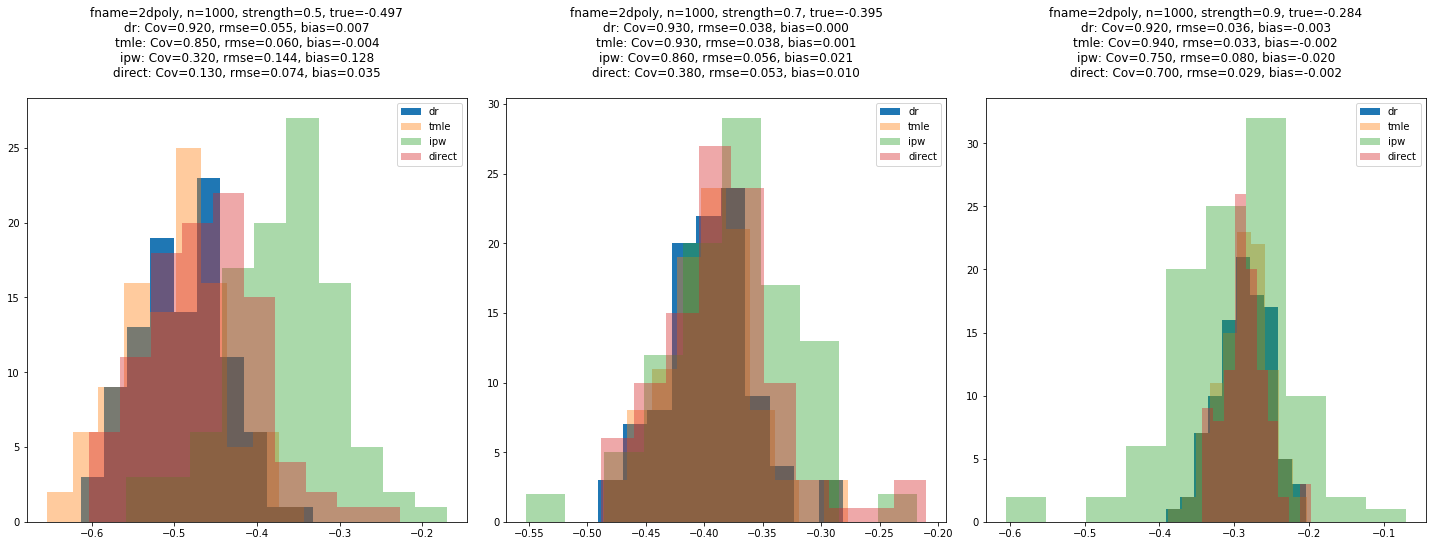

In [52]:
clever = True
for fname in ['2dpoly']:
    plt.figure(figsize=(20, 20))
    it = 1
#     for n in [1000, 2000]:
    for n in [1000]:
        for iv_strength in [.5, .7, .9]:
            plt.subplot(3, 3, it)
            # true, results = joblib.load(f'res_fn_{fname}_n_{n}_stregth_{iv_strength}_eps_{epsilon}.jbl')
            true, results = joblib.load(f'res_fn_{fname}_n_{n}_stregth_{iv_strength}_eps_{epsilon}_clever_{clever}.jbl')
            dr = np.array([r[0] for r in results])
            tmle = np.array([r[1] for r in results])
            ipw = np.array([r[2] for r in results])
            direct = np.array([r[3] for r in results])
            plot_results(fname, n, iv_strength, dr, tmle, ipw, direct, true)
            it += 1
    plt.tight_layout()
    plt.show()

In [130]:
import pandas as pd

clever = True
resd = {}
for fname in ['abs', '2dpoly', 'sigmoid', 'sin']:
    resd[fname] = {}
    for n in [500, 1000]:
        nkey = f'$n={n}$'
        resd[fname][nkey] = {}
        for iv_strength in [.5, .7, .9]:
            true, results = joblib.load(f'res_fn_{fname}_n_{n}_stregth_{iv_strength}_eps_{0.1}_clever_{clever}.jbl')
            ivkey = f'$\rho={iv_strength}$'
            resd[fname][nkey][ivkey] = {}
            for it, method in enumerate(['dr', 'tmle', 'ipw', 'direct']):
                data = np.array([r[it] for r in results])
                if method in ['dr', 'tmle']:
                    cov = f'{100*np.mean((data[:, 1] <= true) & (true <= data[:, 2])):.0f}'
                else:
                    cov = 'NA'
                resd[fname][nkey][ivkey][method] = {
                                'cov': cov,
                                'rmse': f'{np.sqrt(np.mean((data[:, 0]-true)**2)):.3f}',
                                'bias': f'{np.abs(np.mean((data[:, 0]-true))):.3f}'}
            resd[fname][nkey][ivkey] = pd.DataFrame(resd[fname][nkey][ivkey])
        resd[fname][nkey] = pd.concat(resd[fname][nkey])
    resd[fname] = pd.concat(resd[fname])

display(pd.concat(resd).unstack(level=3))
print(pd.concat(resd).unstack(level=3).to_latex(bold_rows=True, multirow=True,
                                                multicolumn=True, escape=False,
                                                column_format='lll||lll|lll|lll|lll|',
                                                multicolumn_format='c|'))

FileNotFoundError: [Errno 2] No such file or directory: 'res_fn_abs_n_500_stregth_0.5_eps_0.1_clever_True.jbl'

In [110]:
import pandas as pd
from collections import OrderedDict


for clever in [False]:
    resd = {}
    for fname in ['abs', '2dpoly', 'sigmoid', 'sin']:
        resd[fname] = OrderedDict()
        for n in [500, 1000, 2000]:
            lambda_l2_h = .1/n**(.9)
            print(lambda_l2_h)
            nkey = f'$n={n}$'
            resd[fname][nkey] = {}
            for iv_strength in [.2, .5, .7, .9]:
                true, results = joblib.load(f'res_fn_{fname}_n_{n}_stregth_{iv_strength}_eps_{0.1}_clever_{clever}_l2h_{lambda_l2_h:.4f}.jbl')
                ivkey = f'$\rho={iv_strength}$'
                resd[fname][nkey][ivkey] = {}
                for it, method in enumerate(['dr', 'tmle', 'ipw', 'direct']):
                    data = np.array([r[it] for r in results])
                    if method in ['dr', 'tmle']:
                        cov = f'{100*np.mean((data[:, 1] <= true) & (true <= data[:, 2])):.0f}'
                    else:
                        cov = 'NA'
                    resd[fname][nkey][ivkey][method] = {
                                    'cov': cov,
                                    'rmse': f'{np.sqrt(np.mean((data[:, 0]-true)**2)):.3f}',
                                    'bias': f'{np.abs(np.mean((data[:, 0]-true))):.3f}'}
                resd[fname][nkey][ivkey] = pd.concat({f'${true:.2f}$': pd.DataFrame(resd[fname][nkey][ivkey])})
            resd[fname][nkey] = pd.concat(resd[fname][nkey], sort=False)
        resd[fname] = pd.concat(resd[fname], sort=False)

    display(pd.concat(resd).unstack(level=4))
    print(pd.concat(resd).unstack(level=4).to_latex(bold_rows=True, multirow=True,
                                                    multicolumn=True, escape=False,
                                                    column_format='lll||lll|lll|lll|lll|',
                                                    multicolumn_format='c|'))

0.00037232911332721384
0.00019952623149688796
0.00010692345999911879
0.00037232911332721384
0.00019952623149688796
0.00010692345999911879
0.00037232911332721384
0.00019952623149688796
0.00010692345999911879
0.00037232911332721384
0.00019952623149688796
0.00010692345999911879


dr              tmle             \
                                      bias cov   rmse   bias cov   rmse   
abs     $n=1000$ $\rho=0.2$ $-0.00$  0.007  95  0.134  0.036  83  0.206   
                 $\rho=0.5$ $-0.00$  0.007  97  0.044  0.006  97  0.045   
                 $\rho=0.7$ $0.00$   0.006  97  0.034  0.006  97  0.034   
                 $\rho=0.9$ $0.00$   0.004  94  0.028  0.004  93  0.028   
        $n=2000$ $\rho=0.2$ $0.00$   0.000  94  0.101  0.007  85  0.117   
                 $\rho=0.5$ $0.00$   0.001  95  0.033  0.000  94  0.033   
                 $\rho=0.7$ $-0.00$  0.001  94  0.026  0.002  93  0.026   
                 $\rho=0.9$ $0.00$   0.001  94  0.022  0.001  95  0.021   
        $n=500$  $\rho=0.2$ $0.00$   0.012  89  0.175  0.021  79  0.572   
                 $\rho=0.5$ $-0.00$  0.016  93  0.068  0.016  93  0.071   
                 $\rho=0.7$ $0.00$   0.010  95  0.047  0.010  94  0.048   
                 $\rho=0.9$ $-0.00$  0.006  90  0.046  0.006  90  0.046   
2dpoly  $n=1000$ $\rho=0.2$ $-0.42$  0.016  91  0.155  0.018  87  0.200   
                 $\rho=0.5$ $-0.50$  0.004  93  0.055  0.005  92  0.055   
                 $\rho=0.7$ $-0.39$  0.006  94  0.040  0.006  93  0.041   
                 $\rho=0.9$ $-0.29$  0.002  94  0.029  0.002  94  0.029   
        $n=2000$ $\rho=0.2$ $-0.42$  0.013  92  0.115  0.005  91  0.124   
                 $\rho=0.5$ $-0.50$  0.001  91  0.043  0.001  91  0.044   
                 $\rho=0.7$ $-0.40$  0.001  93  0.029  0.001  93  0.029   
                 $\rho=0.9$ $-0.28$  0.000  94  0.022  0.000  94  0.022   
        $n=500$  $\rho=0.2$ $-0.42$  0.040  82  0.237  0.020  77  0.524   
                 $\rho=0.5$ $-0.50$  0.007  90  0.093  0.013  90  0.090   
                 $\rho=0.7$ $-0.40$  0.004  90  0.085  0.001  91  0.073   
                 $\rho=0.9$ $-0.28$  0.002  98  0.041  0.004  96  0.040   
sigmoid $n=1000$ $\rho=0.2$ $0.16$   0.016  95  0.110  0.030  86  0.154   
                 $\rho=0.5$ $0.19$   0.001  95  0.036  0.001  93  0.037   
                 $\rho=0.7$ $0.19$   0.000  97  0.026  0.001  97  0.026   
                 $\rho=0.9$ $0.18$   0.001  96  0.021  0.001  94  0.021   
        $n=2000$ $\rho=0.2$ $0.16$   0.009  88  0.076  0.013  87  0.090   
                 $\rho=0.5$ $0.19$   0.000  93  0.024  0.001  91  0.024   
                 $\rho=0.7$ $0.19$   0.001  93  0.018  0.001  93  0.018   
                 $\rho=0.9$ $0.18$   0.000  94  0.018  0.000  94  0.017   
        $n=500$  $\rho=0.2$ $0.16$   0.032  94  0.152  0.008  83  0.491   
                 $\rho=0.5$ $0.19$   0.006  97  0.048  0.004  94  0.052   
                 $\rho=0.7$ $0.19$   0.001  95  0.038  0.000  94  0.033   
                 $\rho=0.9$ $0.18$   0.004  95  0.031  0.003  95  0.030   
sin     $n=1000$ $\rho=0.2$ $0.10$   0.007  92  0.109  0.030  86  0.169   
                 $\rho=0.5$ $0.15$   0.003  93  0.036  0.003  91  0.037   
                 $\rho=0.7$ $0.14$   0.006  93  0.028  0.007  93  0.028   
                 $\rho=0.9$ $0.09$   0.002  98  0.026  0.003  98  0.026   
        $n=2000$ $\rho=0.2$ $0.10$   0.011  91  0.085  0.016  87  0.101   
                 $\rho=0.5$ $0.15$   0.002  95  0.023  0.003  95  0.023   
                 $\rho=0.7$ $0.14$   0.001  96  0.019  0.001  97  0.018   
                 $\rho=0.9$ $0.09$   0.003  94  0.020  0.002  95  0.019   
        $n=500$  $\rho=0.2$ $0.10$   0.027  94  0.158  0.004  82  0.503   
                 $\rho=0.5$ $0.15$   0.002  95  0.051  0.001  92  0.052   
                 $\rho=0.7$ $0.14$   0.010  98  0.034  0.013  94  0.034   
                 $\rho=0.9$ $0.09$   0.012  93  0.037  0.014  92  0.039   

                                       ipw            direct             
                                      bias cov   rmse   bias cov   rmse  
abs     $n=1000$ $\rho=0.2$ $-0.00$  0.007  NA  0.131  0.015  NA  0.090  
                 $\rho=0.5$ $-0.00$  0.005  NA  0.046  0.004  NA  0

\begin{tabular}{lll||lll|lll|lll|lll|}
\toprule
    &         &            &        & \multicolumn{3}{c|}{dr} & \multicolumn{3}{c|}{tmle} & \multicolumn{3}{c|}{ipw} & \multicolumn{3}{c|}{direct} \\
    &         &            &        &   bias & cov &   rmse &   bias & cov &   rmse &   bias & cov &   rmse &   bias & cov &   rmse \\
\midrule
\multirow{12}{*}{\textbf{abs}} & \multirow{4}{*}{\textbf{$n=1000$}} & \textbf{$\rho=0.2$} & \textbf{$-0.00$} &  0.007 &  95 &  0.134 &  0.036 &  83 &  0.206 &  0.007 &  NA &  0.131 &  0.015 &  NA &  0.090 \\
    &         & \textbf{$\rho=0.5$} & \textbf{$-0.00$} &  0.007 &  97 &  0.044 &  0.006 &  97 &  0.045 &  0.005 &  NA &  0.046 &  0.004 &  NA &  0.053 \\
    &         & \textbf{$\rho=0.7$} & \textbf{$0.00$} &  0.006 &  97 &  0.034 &  0.006 &  97 &  0.034 &  0.004 &  NA &  0.034 &  0.002 &  NA &  0.052 \\
    &         & \textbf{$\rho=0.9$} & \textbf{$0.00$} &  0.004 &  94 &  0.028 &  0.004 &  93 &  0.028 &  0.001 &  NA &  0.036 &  0.002 &  NA & 

In [114]:
import pandas as pd

for clever in [True]:
    resd = {}
    for fname in ['2dpoly']:
        resd[fname] = {}
        for n in [2000, 20000]:
            lambda_l2_h = .1/n**(.9)
            print(lambda_l2_h)
            nkey = f'$n={n}$'
            resd[fname][nkey] = {}
            for iv_strength in [.01, .05, .1]:
                true, results = joblib.load(f'res_fn_{fname}_n_{n}_stregth_{iv_strength}_eps_{0.1}_clever_{clever}_l2h_{lambda_l2_h:.4f}.jbl')
                ivkey = f'$\rho={iv_strength}$'
                resd[fname][nkey][ivkey] = {}
                for it, method in enumerate(['dr', 'tmle', 'ipw', 'direct']):
                    data = np.array([r[it] for r in results])
                    if method in ['dr', 'tmle']:
                        cov = f'{100*np.mean((data[:, 1] <= true) & (true <= data[:, 2])):.0f}'
                    else:
                        cov = 'NA'
                    resd[fname][nkey][ivkey][method] = {
                                    'cov': cov,
                                    '$\\frac{\\textbf{rmse}}{|\\theta^*|}$': f'{np.sqrt(np.mean((data[:, 0]-true)**2))/np.abs(true):.3f}',
                                    '$\\frac{\\textbf{bias}}{|\\theta^*|}$': f'{np.abs(np.mean((data[:, 0]-true)))/np.abs(true):.3f}'}
                resd[fname][nkey][ivkey] = pd.DataFrame(resd[fname][nkey][ivkey])
            resd[fname][nkey] = pd.concat(resd[fname][nkey])
        resd[fname] = pd.concat(resd[fname])

    display(pd.concat(resd).unstack(level=3))
    print(pd.concat(resd).unstack(level=3).to_latex(bold_rows=True, multirow=True,
                                                    multicolumn=True, escape=False,
                                                    column_format='lll||lll|lll|lll|lll|',
                                                    multicolumn_format='c|'))
    print(resd['2dpoly'].unstack(level=2).to_latex(bold_rows=True, multirow=True,
                                                    multicolumn=True, escape=False,
                                                    column_format='ll||lll|lll|lll|lll|',
                                                    multicolumn_format='c|'))

0.00010692345999911879
1.3460866090984778e-05


dr                                     \
                             cov $\frac{\textbf{rmse}}{|\theta^*|}$   
2dpoly $n=2000$  $\rho=0.01$  95                              2.236   
                 $\rho=0.05$  92                              1.567   
                 $\rho=0.1$   90                              0.700   
       $n=20000$ $\rho=0.01$  93                             12.396   
                 $\rho=0.05$  90                              1.276   
                 $\rho=0.1$   87                              0.344   

                                                                tmle  \
                             $\frac{\textbf{bias}}{|\theta^*|}$  cov   
2dpoly $n=2000$  $\rho=0.01$                              0.585   97   
                 $\rho=0.05$                              0.507   92   
                 $\rho=0.1$                               0.168   86   
       $n=20000$ $\rho=0.01$                              0.278  100   
                 $\rho=0.05$                              0.045   97   
                 $\rho=0.1$                               0.034   90   

                                                                 \
                             $\frac{\textbf{rmse}}{|\theta^*|}$   
2dpoly $n=2000$  $\rho=0.01$                             17.123   
                 $\rho=0.05$                             15.136   
                 $\rho=0.1$                               4.341   
       $n=20000$ $\rho=0.01$                             45.362   
                 $\rho=0.05$                              6.172   
                 $\rho=0.1$                               0.373   

                                                                ipw  \
                             $\frac{\textbf{bias}}{|\theta^*|}$ cov   
2dpoly $n=2000$  $\rho=0.01$                              1.118  NA   
                 $\rho=0.05$                              0.017  NA   
                 $\rho=0.1$                               0.434  NA   
       $n=20000$ $\rho=0.01$                              6.650  NA   
                 $\rho=0.05$                              0.417  NA   
                 $\rho=0.1$                               0.007  NA   

                                                                 \
                             $\frac{\textbf{rmse}}{|\theta^*|}$   
2dpoly $n=2000$  $\rho=0.01$                              3.027   
                 $\rho=0.05$                              1.985   
                 $\rho=0.1$                               0.835   
       $n=20000$ $\rho=0.01$                             13.696   
                 $\rho=0.05$                              1.377   
                 $\rho=0.1$                               0.371   

                                                                direct  \
                             $\frac{\textbf{bias}}{|\theta^*|}$    cov   
2dpoly $n=2000$  $\rho=0.01$                              1.015     NA   
                 $\rho=0.05$                              0.679     NA   
                 $\rho=0.1$                               0.336     NA   
       $n=20000$ $\rho=0.01$                              0.483     NA   
                 $\rho=0.05$                              0.046     NA   
                 $\rho=0.1$                               0.043     NA   

                                                                 \
                             $\frac{\textbf{rmse}}{|\theta^*|}$   
2dpoly $n=2000$  $\rho=0.01$                              0.746   
                 $\rho=0.05$                              0.710   
                 $\rho=0.1$                               0.512   
       $n=20000$ $\rho=0.01$                              0.704   
                 $\rho=0.05$                              0.626   
                 $\rho=0.1$                               0.588   

                                                                 
                             $\frac{\textbf{b

\begin{tabular}{lll||lll|lll|lll|lll|}
\toprule
       &           &            & \multicolumn{3}{c|}{dr} & \multicolumn{3}{c|}{tmle} & \multicolumn{3}{c|}{ipw} & \multicolumn{3}{c|}{direct} \\
       &           &            & cov & $\frac{\textbf{rmse}}{|\theta^*|}$ & $\frac{\textbf{bias}}{|\theta^*|}$ &  cov & $\frac{\textbf{rmse}}{|\theta^*|}$ & $\frac{\textbf{bias}}{|\theta^*|}$ & cov & $\frac{\textbf{rmse}}{|\theta^*|}$ & $\frac{\textbf{bias}}{|\theta^*|}$ &    cov & $\frac{\textbf{rmse}}{|\theta^*|}$ & $\frac{\textbf{bias}}{|\theta^*|}$ \\
\midrule
\multirow{6}{*}{\textbf{2dpoly}} & \multirow{3}{*}{\textbf{$n=2000$}} & \textbf{$\rho=0.01$} &  95 &                              2.236 &                              0.585 &   97 &                             17.123 &                              1.118 &  NA &                              3.027 &                              1.015 &     NA &                              0.746 &                              0.651 \\
       &          

In [62]:
1/np.sqrt(2000)

0.022360679774997897